In [1]:
from sklearn.decomposition import PCA
import numpy as np
import h5py

def inspect_h5(file):
    """
    Inspect the structure of an HDF5 file.

    Args:
        file (str): Path to the HDF5 file.
    """
    with h5py.File(file, 'r') as f:
        print(f"Inspecting {file}:")
        print(f['008bd5ad93b754d5'])
        for key in f.keys():
            print(f"{key}: {list(f[key].keys()) if isinstance(f[key], h5py.Group) else 'Dataset'}")
# Inspect descriptors and keypoints files
inspect_h5("../data/feature_descriptors/descriptors.h5")
#inspect_h5("../data/feature_descriptors/keypoints.h5")

Inspecting ../data/feature_descriptors/descriptors.h5:
<HDF5 dataset "008bd5ad93b754d5": shape (2069, 128), type "<f4">
0004d0b59e19461f: Dataset
000871c1fc726f0b: Dataset
0084ae4bc24c0795: Dataset
008bd5ad93b754d5: Dataset
00b76fddeaaa7d8c: Dataset
00ec53c4682d36f5: Dataset
01161aaa0b6d1345: Dataset
01386bd6d8e091c2: Dataset
01882513d5fa7c32: Dataset
0189caa552598b84: Dataset
018b59ce1fd616d8: Dataset
01931a6925d3de09: Dataset
019d385eb67632a7: Dataset
01f78be6f7cad026: Dataset
020bf2c45e7bb322: Dataset
022400dffec5b447: Dataset
0233f3bb964cf325: Dataset
0266e33d3f546cb5: Dataset
026a39ae63343c68: Dataset
02a32ad2669e6fe2: Dataset
02b5b45ce743bc3f: Dataset
0314c9b108b8c39f: Dataset
032dd17b77fab7d5: Dataset
0336dcbab05b9d5a: Dataset
037a595e6f4f0576: Dataset
03bfc1d4783966c6: Dataset
03c6b06952c75089: Dataset
03e0704b5690a2de: Dataset
03e7d2ebec1e820a: Dataset
03f5446139179452: Dataset
03fa2f7502f5f6b9: Dataset
04025959b191f8f9: Dataset
0415740eaa4d9dec: Dataset
043ab21fc5a1607b: Data

In [12]:
def load_keypoints_and_descriptors(keypoins_file, descriptors_file):
    data = {}
    with h5py.File(keypoins_file, 'r') as kf, h5py.File(descriptors_file, 'r') as df:
        for key in kf.keys():
            if key in df:
                keypoints = np.array(kf[key])
                descriptors = np.array(df[key])
                data[key] = (keypoints, descriptors)
            else:
                print(f"Key {key} not found in descriptors file.")
    return data

keypoints_file = "../data/feature_descriptors/keypoints.h5"
descriptors_file = "../data/feature_descriptors/descriptors.h5"

dataset = load_keypoints_and_descriptors(keypoints_file, descriptors_file)
print(f"Loaded dataset with {len(dataset)} images.")
    

Loaded dataset with 1887 images.


In [2]:
def load_descriptors_in_chunks(file, max_samples=None):
    descriptors = []
    with h5py.File(file, 'r') as f:
        for image_id in f.keys():
            desc = np.array(f[image_id])
            descriptors.append(desc)

            # Stop if max_samples is reached
            if max_samples and len(descriptors) >= max_samples:
                break

    # Combine all descriptors into a single array
    return np.vstack(descriptors)

In [3]:
descriptor_file = "../data/feature_descriptors/descriptors.h5"  # Replace with your path
max_samples = 500  # Load only the first 10,000 descriptors for testing
all_descriptors = load_descriptors_in_chunks(descriptor_file, max_samples=max_samples)
print(f"Loaded {all_descriptors.shape[0]} descriptors with shape {all_descriptors.shape[1]}.")

Loaded 921822 descriptors with shape 128.


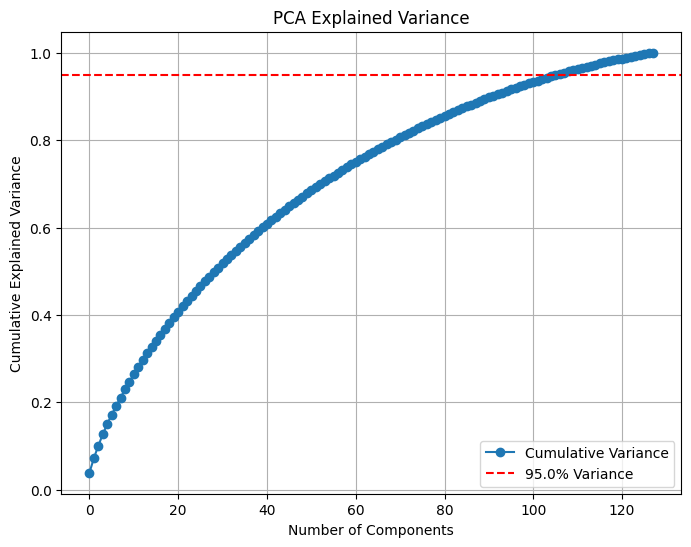

Optimal PCA components: 107


In [5]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def test_pca_variance(descriptors, variance_threshold = 0.95):
    pca = PCA().fit(descriptors)
    explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
    # Plot the explained variance
    plt.figure(figsize=(8, 6))
    plt.plot(explained_variance_ratio, marker='o', label="Cumulative Variance")
    plt.axhline(y=variance_threshold, color='r', linestyle='--', label=f"{variance_threshold * 100}% Variance")
    plt.xlabel("Number of Components")
    plt.ylabel("Cumulative Explained Variance")
    plt.title("PCA Explained Variance")
    plt.legend()
    plt.grid()
    plt.show()

    # Find the optimal number of components
    optimal_components = np.argmax(explained_variance_ratio >= variance_threshold) + 1
    return pca, optimal_components

# Example usage
pca_model, optimal_pca_components = test_pca_variance(all_descriptors)
print(f"Optimal PCA components: {optimal_pca_components}")

In [12]:
def train_pca(descriptor_file, n_components):

    descriptors = []
    with h5py.File(descriptor_file, 'r') as f:
        for image_id in f.keys():
            descriptors.append(np.array(f[image_id]))
    all_descriptors = np.vstack(descriptors)

    # Train PCA
    pca = PCA(n_components=n_components)
    pca.fit(all_descriptors)
    print(f"PCA trained with {n_components} components.")
    return pca

# Example usage
descriptor_file = "../data/feature_descriptors/descriptors.h5"
n_components = optimal_pca_components  # Set based on explained variance (e.g., 95%)
pca_model = train_pca(descriptor_file, n_components)

: 

Trained GMM with 1 components.
Trained GMM with 2 components.
Trained GMM with 3 components.
Trained GMM with 4 components.


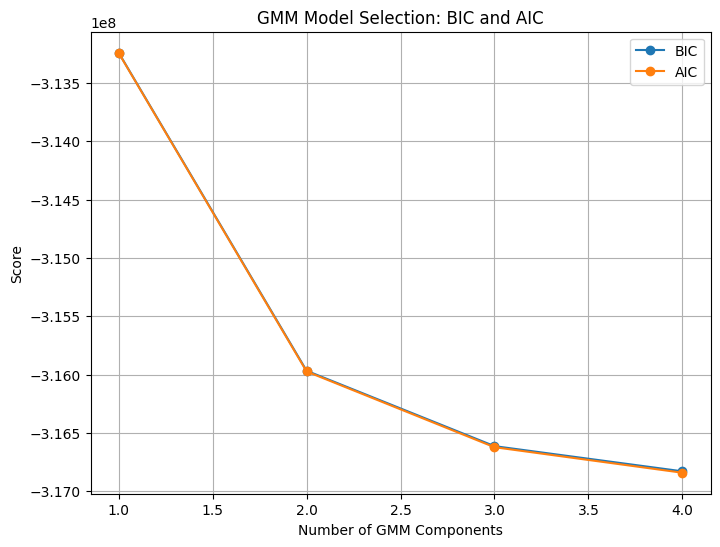

In [11]:
from sklearn.mixture import GaussianMixture
def test_gmm_components(descriptors, n_components_range, covariance_type='diag'):

    bic_scores = []
    aic_scores = []

    for n_components in n_components_range:
        gmm = GaussianMixture(n_components=n_components, covariance_type=covariance_type, random_state=42)
        gmm.fit(descriptors)

        # Record BIC and AIC scores
        bic_scores.append(gmm.bic(descriptors))
        aic_scores.append(gmm.aic(descriptors))
        print(f"Trained GMM with {n_components} components.")

    # Plot BIC and AIC
    plt.figure(figsize=(8, 6))
    plt.plot(n_components_range, bic_scores, label="BIC", marker='o')
    plt.plot(n_components_range, aic_scores, label="AIC", marker='o')
    plt.xlabel("Number of GMM Components")
    plt.ylabel("Score")
    plt.title("GMM Model Selection: BIC and AIC")
    plt.legend()
    plt.grid()
    plt.show()

    return {"bic": bic_scores, "aic": aic_scores}

# Reduce dimensionality with PCA first
reduced_descriptors = pca_model.transform(all_descriptors)
# Test GMM components
n_components_range = range(1, 5)  # Test GMM with 1 to 10 components
gmm_scores = test_gmm_components(reduced_descriptors, n_components_range)